# script to get V1 from freesurfer

In [10]:
import nibabel as nb
import numpy as np
import hcp_utils

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [60]:
with open('pilots_ru_dm_list.txt', 'r') as file:
    sub_list = file.readlines()
good_subjects_list = [line.strip() for line in sub_list]
good_subjects_list.remove('NDARUT018UYN')

#NDARUT018UYN DNE
#error: MRISread(/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/freesurfer_7.3.2/sub-NDARUT018UYN/surf/lh.white): could not open file

In [61]:
v1_list=[]
for sub in good_subjects_list:
    #sub='NDARHJ830RXD'
    im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    
    label_gii = nib.load(f'/om2/scratch/tmp/jsmentch/nat_asd/outputs/v1_roi/sub-{sub}_V1.dlabel.nii')
    label_data = label_gii.get_fdata()
    _,ind=np.where(label_data==2)
    
    
    img_cortex=[]
    for i in np.arange(img_y.shape[0]):
        img_cortex.append(hcp_utils.cortex_data(img_y[i,:])[ind])
    np.asanyarray(img_cortex)
    v1_list.append(np.asanyarray(img_cortex))

In [64]:
np.mean(v1_list[0],axis=1).shape

(750,)

In [139]:
# # Basic statistics
# grand_mean = np.mean(timecourse)
# variance = np.var(timecourse)
# std_dev = np.std(timecourse)

# # Measures of fluctuation
# range_ = np.ptp(timecourse)
# iqr = np.percentile(timecourse, 75) - np.percentile(timecourse, 25)
# mad = np.mean(np.abs(timecourse - mean))
# cv = std_dev / mean

# # Temporal dynamics
# autocorrelation = np.correlate(timecourse, timecourse, mode='full') / np.var(timecourse) / len(timecourse)
# autocorrelation = autocorrelation[autocorrelation.size // 2:]
"""
Basic Statistics
Mean: The average value of the timecourse.
Variance: A measure of the spread of the timecourse values around the mean.
Standard Deviation: The square root of the variance, indicating how much the values typically deviate from the mean.
Measures of Fluctuation
Range: The difference between the maximum and minimum values.
Interquartile Range (IQR): The difference between the 75th and 25th percentiles, showing the range within which the middle 50% of the data lie.
Mean Absolute Deviation (MAD): The average of the absolute deviations from the mean.
Coefficient of Variation (CV): The ratio of the standard deviation to the mean, indicating the relative variability.
"""



import numpy as np
from scipy.signal import correlate, welch, find_peaks
from scipy.stats import skew, kurtosis, variation


# Define a function to calculate RMS
def compute_rms(timecourse):
    return np.sqrt(np.mean(np.square(timecourse)))

# Compute skewness and kurtosis
def compute_skewness(timecourse):
    return skew(timecourse)

def compute_kurtosis(timecourse):
    return kurtosis(timecourse)


metrics_z = {
    'grand_mean': [],
    'mean_variance': [],
    'mean_std_dev': [],
    'mean_range': [],
    'mean_iqr': [],
    'mean_mad': [],
    'mean_cv': [],
    'grand_autocorrelation': [],
    'grand_psd': [],
    'grand_rms': [],
    'grand_peak_count': [],
    'grand_peak_amplitude': [],
    'grand_peak_frequency': [],
    'grand_skewness': [],
    'grand_kurtosis': [],
}


v1_list_z=nat_asd_utils.apply_zscore(v1_list)

for v in v1_list_z:
    v_mean=np.mean(v,axis=1)
    metrics_z['grand_mean'].append(np.mean(v_mean))
    metrics_z['mean_variance'].append(np.var(v_mean))
    metrics_z['mean_std_dev'].append(np.std(v_mean))
    metrics_z['mean_range'].append(np.ptp(v_mean))
    metrics_z['mean_iqr'].append(np.percentile(v_mean, 75) - np.percentile(v_mean, 25))
    metrics_z['mean_mad'].append(np.mean(np.abs(v_mean - np.mean(v_mean))))
    metrics_z['mean_cv'].append(np.std(v_mean)/np.mean(v_mean))

    # Compute Autocorrelation
    v_autocorr = correlate(v_mean, v_mean, mode='full')
    v_autocorr = v_autocorr[v_autocorr.size // 2:]  # Keep positive lags
    metrics_z['grand_autocorrelation'].append(np.mean(v_autocorr))

    # Compute Power Spectral Density (PSD)
    freqs, psd = welch(v_mean)
    metrics_z['grand_psd'].append(np.mean(psd))  # Mean PSD

    # Compute Root Mean Square (RMS)
    metrics_z['grand_rms'].append(compute_rms(v_mean))

    # Peak Detection
    peaks, _ = find_peaks(v_mean)
    peak_count = float(len(peaks))
    metrics_z['grand_peak_count'].append(float(peak_count))
    
    # Amplitude of Peaks
    peak_amplitudes = v_mean[peaks] if peak_count > 0 else np.array([])
    if peak_count > 0:
        mean_peak_amplitude = np.mean(peak_amplitudes)
    else:
        mean_peak_amplitude = 0
    metrics_z['grand_peak_amplitude'].append(mean_peak_amplitude)

    # Peak Frequency
    if peak_count > 0:
        peak_frequency = peak_count / len(v_mean)  # Peaks per sample
    else:
        peak_frequency = 0
    metrics_z['grand_peak_frequency'].append(peak_frequency)

    metrics_z['grand_skewness'].append(compute_skewness(v_mean))
    metrics_z['grand_kurtosis'].append(compute_kurtosis(v_mean))

/tmp/ipykernel_2645693/3839334371.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  metrics_z['mean_cv'].append(np.std(v_mean)/np.mean(v_mean))


In [141]:
#repeat but for z-scored
import nat_asd_utils

# Define a function to calculate RMS
def compute_rms(timecourse):
    return np.sqrt(np.mean(np.square(timecourse)))

# Compute skewness and kurtosis
def compute_skewness(timecourse):
    return skew(timecourse)

def compute_kurtosis(timecourse):
    return kurtosis(timecourse)

metrics = {
    'StackedR2': [],
    'grand_mean': [],
    'mean_variance': [],
    'mean_std_dev': [],
    'mean_range': [],
    'mean_iqr': [],
    'mean_mad': [],
    'mean_cv': [],
    'grand_autocorrelation': [],
    'grand_psd': [],
    'grand_rms': [],
    'grand_peak_count': [],
    'grand_peak_amplitude': [],
    'grand_peak_frequency': [],
    'grand_skewness': [],
    'grand_kurtosis': []
}

for v in v1_list:
    v_mean=np.mean(v,axis=1)
    metrics['grand_mean'].append(np.mean(v_mean))
    metrics['mean_variance'].append(np.var(v_mean))
    metrics['mean_std_dev'].append(np.std(v_mean))
    metrics['mean_range'].append(np.ptp(v_mean))
    metrics['mean_iqr'].append(np.percentile(v_mean, 75) - np.percentile(v_mean, 25))
    metrics['mean_mad'].append(np.mean(np.abs(v_mean - np.mean(v_mean))))
    metrics['mean_cv'].append(np.std(v_mean)/np.mean(v_mean))

    # Compute Autocorrelation
    v_autocorr = correlate(v_mean, v_mean, mode='full')
    v_autocorr = v_autocorr[v_autocorr.size // 2:]  # Keep positive lags
    metrics['grand_autocorrelation'].append(np.mean(v_autocorr))

    # Compute Power Spectral Density (PSD)
    freqs, psd = welch(v_mean)
    metrics['grand_psd'].append(np.mean(psd))  # Mean PSD

    # Compute Root Mean Square (RMS)
    metrics['grand_rms'].append(compute_rms(v_mean))

    # Peak Detection
    peaks, _ = find_peaks(v_mean)
    peak_count = float(len(peaks))
    metrics['grand_peak_count'].append(float(peak_count))
    
    # Amplitude of Peaks
    peak_amplitudes = v_mean[peaks] if peak_count > 0 else np.array([])
    if peak_count > 0:
        mean_peak_amplitude = np.mean(peak_amplitudes)
    else:
        mean_peak_amplitude = 0
    metrics['grand_peak_amplitude'].append(mean_peak_amplitude)

    # Peak Frequency
    if peak_count > 0:
        peak_frequency = peak_count / len(v_mean)  # Peaks per sample
    else:
        peak_frequency = 0
    metrics['grand_peak_frequency'].append(peak_frequency)

    metrics['grand_skewness'].append(compute_skewness(v_mean))
    metrics['grand_kurtosis'].append(compute_kurtosis(v_mean))

/tmp/ipykernel_2645693/2919747136.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.asanyarray(metrics_z[m])/max(metrics_z[m]),label=f'{m}_z')


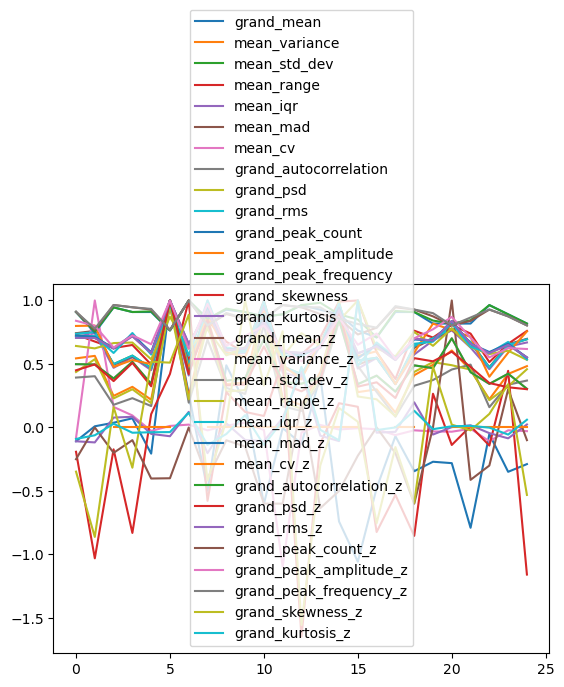

In [142]:
import matplotlib.pyplot as plt
for m in metrics:
    plt.plot(np.asanyarray(metrics[m])/max(metrics[m]),label=m)
    plt.legend()
for m in metrics_z:
    plt.plot(np.asanyarray(metrics_z[m])/max(metrics_z[m]),label=f'{m}_z')
    plt.legend()


In [146]:
stackedr2_list=[]
mean_stackedr2_list=[]

for sub in good_subjects_list:
#sub=sub_list[0]
    #loaded=np.load(f'../pilot_results/feat-audio_sub-{sub}_ROI-all_PCA-1_delay-6.npz')
    loaded=np.load(f'../good_pilots/sub-{sub}_roi-a4a5_feat-cochresnet50srp05hrfssfirst_delay-0.npz')

    stackedr2_list.append(loaded['stacked_r2s'])
    mean_stackedr2_list.append(loaded['stacked_r2s'].mean())
#sub-NDAREM731BYM_roi-a4a5_feat-cochresnet50srp05hrfssfirst_delay-0.npz

In [150]:
metrics['StackedR2']=mean_stackedr2_list

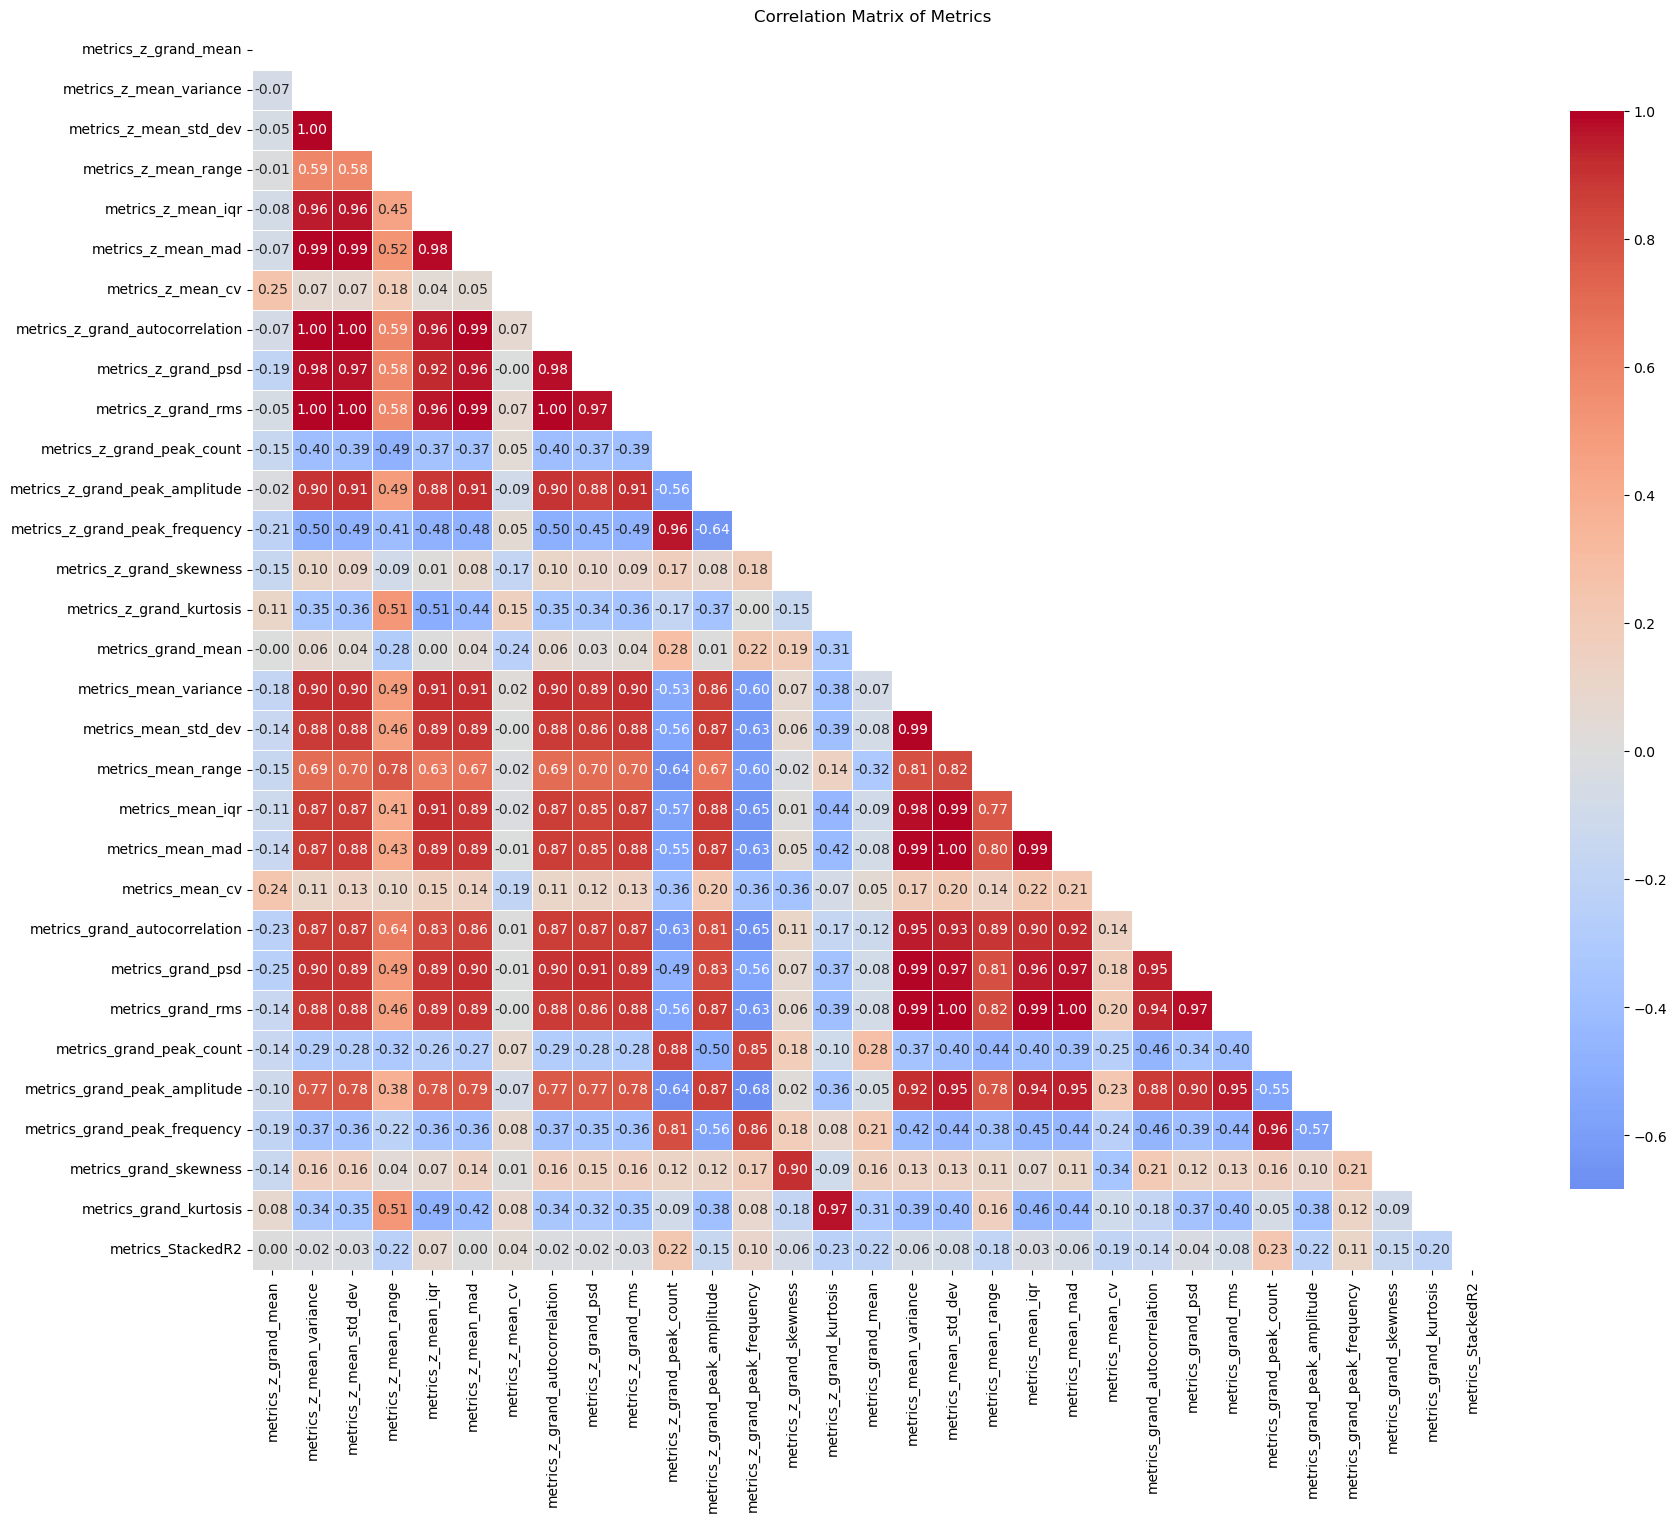

In [158]:
import pandas as pd
import seaborn as sns

# Convert dictionaries to DataFrames
df_metrics = pd.DataFrame(metrics)
df_metrics_z = pd.DataFrame(metrics_z)

# Combine DataFrames
df_combined = pd.concat([df_metrics_z, df_metrics], axis=1, keys=['metrics_z', 'metrics'])

# Flatten MultiIndex columns
df_combined.columns = ['_'.join(col) for col in df_combined.columns]

# Compute correlation matrix
corr_matrix = df_combined.corr()

# # Plot the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix of Metrics')
# plt.show()




mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Choose a custom colormap (e.g., 'coolwarm')
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Plot the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, center=0,
            square=True, fmt='.2f',linewidths=.5, cbar_kws={"shrink": 0.7})


# plt.xticks( np.arange(len(feature_names))+.5, feature_names, rotation=45)
# plt.yticks( np.arange(len(feature_names))+.5, feature_names, rotation=0)
plt.title("Correlation Matrix of Metrics")

plt.show()

In [39]:
test_img=hcp_utils.cortex_data(img_y[0])
test_img=test_img*(label_data-1)


In [40]:
plotting.view_surf(hcp_utils.mesh.inflated, surf_map=test_img)

In [ ]:
metrics = {
    'grand_mean': [],
}


for v in v1_list:
    v_mean=np.mean(v,axis=1)
    metrics['grand_mean'].append(np.mean(v_mean))